In [52]:
import jupyter_Importer
from MLModels_FeatureImportance import featureImportance_linearRegression
from MLModels_FeatureImportance import featureImportance_permutation
from MLModels_FeatureImportance import featureImportance_DTree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import warnings
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')



In [53]:
dataset = pd.read_csv("cmc.csv",names=['x' + str(i) for i in range(1,11)] + ['y'],sep = ";")
dataset.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,ID,age,Weducation,Heducation,children,religion,working,occupation,solindex,exposure,method
1,1,24,2,3,3,1,1,2,3,0,1
2,2,45,1,3,10,1,1,3,4,0,1
3,3,43,2,3,7,1,1,3,4,0,1
4,4,42,3,2,9,1,1,3,3,0,1


In [54]:
#pick two columns
from sklearn import preprocessing
dataset_2col = dataset.loc[1:,['x2','x5']]#numerical columns:age,childern
#dataset_2col['y'] = dataset.iloc[1:,10:11]
dataset_2col.columns = ['x1','x2']
dataset_2col['x1'] = dataset_2col['x1'].apply(lambda x : float(x))
dataset_2col['x2'] = dataset_2col['x2'].apply(lambda x : float(x))
#dataset_2col['y'] = dataset_2col['y'].apply(lambda x : int(x))

minmax = preprocessing.MinMaxScaler()
dataset_2col = minmax.fit_transform(dataset_2col)
dataset_2col = pd.DataFrame(dataset_2col)
dataset_2col['y'] = dataset.iloc[1:,10:11]
dataset_2col.columns = ['x1','x2','y']
dataset_2col[dataset_2col.isnull().values==True]
dataset_2col = dataset_2col.dropna()
dataset_2col['y'] = dataset_2col['y'].apply(lambda x : int(x))
subset = dataset_2col.sample(frac=0.1,replace=False,random_state=43)
subset_x = subset.iloc[:,:-1]
subset_y = subset.iloc[:,-1]
dataset_2col


,x1,x2,y
1,0.878788,0.6250,1
2,0.818182,0.4375,1
3,0.787879,0.5625,1
4,0.606061,0.5000,1
5,0.090909,0.0000,1
...,...,...,...
1468,0.515152,0.1250,3
1469,0.515152,0.1875,3
1470,0.696970,0.5000,3
1471,0.515152,0.2500,3


In [55]:
importanceMeasure_x = dataset_2col.iloc[:,:-1]
importanceMeasure_y = dataset_2col.iloc[:,-1]
importanceReg,RegCoef = featureImportance_linearRegression(importanceMeasure_x,importanceMeasure_y)
model = KNeighborsClassifier(n_neighbors=2,algorithm="brute")  ## k = 5
model.fit(subset_x,subset_y)  
# model = KMeans(n_clusters=2,init='random')
# model.fit(subset_x,subset_y)
importancePermu,PermuCoef = featureImportance_permutation(model,subset_x,subset_y)
importanceDTree,DTreeCoef = featureImportance_DTree(subset_x,subset_y)
print("RegCoef : " +str(RegCoef))
print("importanceReg : "+str(importanceReg))
print("PermuCoef : "+str(PermuCoef))
print("importancePermu : "+str(importancePermu))
print("DTreeCoef : " +str(DTreeCoef))
print("importanceDTree : "+str(importanceDTree))

RegCoef : [-1.0350313041990595, 1.4360751328108052]
importanceReg : [0.41885338838398556, 0.5811466116160146]
PermuCoef : [0.34557823129251697, 0.3265306122448979]
importancePermu : [0.51417004048583, 0.48582995951417]
DTreeCoef : [0.599367841494458, 0.40063215850554207]
importanceDTree : [0.599367841494458, 0.40063215850554207]


In [56]:
def makeBEdata_4direc(X=dataset_2col,BE=0.1,importance = [0.5,0.5]):
    #pd.set_option('display.max_rows',10)
    temp = X.copy()
    df_2feature_be = pd.DataFrame.to_numpy(temp)
    e1 = temp['x1'].mean()*BE*importance[0]
    e2 = temp['x2'].mean()*BE*importance[1]

    for idx,cell in temp['x1'].iteritems():
        temp['x1'][idx] += e1
    temp = temp.to_numpy()
    df_2feature_be = np.vstack((df_2feature_be,temp))
    temp = X.copy()

    for idx,cell in temp['x1'].iteritems():
        temp['x1'][idx] = temp['x1'][idx] - e1
    temp = temp.to_numpy()
    df_2feature_be = np.vstack((df_2feature_be,temp))
    temp = X.copy()

    for idx,cell in temp['x2'].iteritems():
        temp['x2'][idx] += e2
    temp = temp.to_numpy()
    df_2feature_be = np.vstack((df_2feature_be,temp))
    temp = X.copy()

    for idx,cell in temp['x2'].iteritems():
        temp['x2'][idx] = temp['x2'][idx] - e2
    temp = temp.to_numpy()
    df_2feature_be = np.vstack((df_2feature_be,temp))
    temp = X.copy()

    df_2feature_be = pd.DataFrame(df_2feature_be)
    return df_2feature_be


In [57]:
#ch4 generate accuracy of applying FI in data with 2% - 14% err
#svm,cmc,importanceReg,Permu,DTree
BEn = [0.02,0.04,0.06,0.08,0.1,0.12,0.14]
BEAcclist_svm_importanceReg = []
BEAcclist_svm_importancePermu = []
BEAcclist_svm_importanceDTree = []
BEAcclist_svm = []

for i in BEn :
    df_2feature_be = makeBEdata_4direc(X=dataset_2col,BE=i,importance=importanceReg)
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values
    #for j in range(30):
    X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.2)
    clf_BE = SVC(kernel='linear',C=1,gamma='auto')
    clf_BE.fit(X_train, y_train)
    y_BE_predict = clf_BE.predict(X_test)
    result_BE_train = clf_BE.score(X_train, y_train)
    result_BE_test = clf_BE.score(X_test, y_test)
    BEAcclist_svm_importanceReg.append(result_BE_test)
    print('BESVM Accuracy (on training) = with importanceReg bounded error '+str(i)+' : '+str(result_BE_train))
    print('BESVM Accuracy (on testing) = with importanceReg bounded error '+str(i)+' : '+str(result_BE_test))
    #result_BE_train = 0
    #result_BE_test = 0

for i in BEn :
    df_2feature_be = makeBEdata_4direc(X=dataset_2col,BE=i,importance=importancePermu)
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values
    for j in range(30):
        X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.2)
        clf_BE = SVC(kernel='linear',C=1,gamma='auto')
        clf_BE.fit(X_train, y_train)
        y_BE_predict = clf_BE.predict(X_test)
        result_BE_train += clf_BE.score(X_train, y_train)
        result_BE_test += clf_BE.score(X_test, y_test)
    BEAcclist_svm_importancePermu.append(result_BE_test/31)
    print('BESVM Accuracy (on training) = with importancePermu bounded error '+str(i)+' : '+str(result_BE_train/31))
    print('BESVM Accuracy (on testing) = with  importancePermu bounded error '+str(i)+' : '+str(result_BE_test/31))
    result_BE_train = 0
    result_BE_test = 0

for i in BEn :
    df_2feature_be = makeBEdata_4direc(X=dataset_2col,BE=i,importance=importanceDTree)
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values
    for j in range(30):
        X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.2)
        clf_BE = SVC(kernel='linear',C=1,gamma='auto')
        clf_BE.fit(X_train, y_train)
        y_BE_predict = clf_BE.predict(X_test)
        result_BE_train += clf_BE.score(X_train, y_train)
        result_BE_test += clf_BE.score(X_test, y_test)
    BEAcclist_svm_importanceDTree.append(result_BE_test/31)
    print('BESVM Accuracy (on training) = with importanceDTree bounded error '+str(i)+' : '+str(result_BE_train/31))
    print('BESVM Accuracy (on testing) = with  importanceDTree bounded error '+str(i)+' : '+str(result_BE_test/31))
    result_BE_train = 0
    result_BE_test = 0

for i in BEn :
    df_2feature_be = makeBEdata_4direc(X=dataset_2col,BE=i)#0.5:0.5
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values
    for j in range(30):
        X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.2)
        clf_BE = SVC(kernel='linear',C=1,gamma='auto')
        clf_BE.fit(X_train, y_train)
        y_BE_predict = clf_BE.predict(X_test)
        result_BE_train += clf_BE.score(X_train, y_train)
        result_BE_test += clf_BE.score(X_test, y_test)
    BEAcclist_svm.append(result_BE_test/31)
    print('BESVM Accuracy (on training) = with 1:1 bounded error '+str(i)+' : '+str(result_BE_train/31))
    print('BESVM Accuracy (on testing) = with  1:1 bounded error '+str(i)+' : '+str(result_BE_test/31))
    result_BE_train = 0
    result_BE_test = 0


BESVM Accuracy (on training) = with importanceReg bounded error 0.02 : 0.48029891304347827
BESVM Accuracy (on testing) = with importanceReg bounded error 0.02 : 0.47622282608695654
BESVM Accuracy (on training) = with importanceReg bounded error 0.04 : 0.47690217391304346
BESVM Accuracy (on testing) = with importanceReg bounded error 0.04 : 0.483695652173913
BESVM Accuracy (on training) = with importanceReg bounded error 0.06 : 0.48029891304347827
BESVM Accuracy (on testing) = with importanceReg bounded error 0.06 : 0.4741847826086957
BESVM Accuracy (on training) = with importanceReg bounded error 0.08 : 0.483695652173913
BESVM Accuracy (on testing) = with importanceReg bounded error 0.08 : 0.45991847826086957
BESVM Accuracy (on training) = with importanceReg bounded error 0.1 : 0.4752038043478261
BESVM Accuracy (on testing) = with importanceReg bounded error 0.1 : 0.469429347826087
BESVM Accuracy (on training) = with importanceReg bounded error 0.12 : 0.47758152173913043
BESVM Accuracy

In [58]:
print(BEAcclist_svm_importanceReg)
print(BEAcclist_svm_importancePermu)
print(BEAcclist_svm_importanceDTree)
print(BEAcclist_svm)

[0.47622282608695654, 0.483695652173913, 0.4741847826086957, 0.45991847826086957, 0.469429347826087, 0.4782608695652174, 0.48165760869565216]
[0.4794442496493688, 0.46408222300140245, 0.46169354838709675, 0.4628550140252454, 0.46171546283309955, 0.46644898316970546, 0.4630084151472651]
[0.4629645862552595, 0.4662298387096775, 0.4632494740532958, 0.4613867461430574, 0.4612552594670407, 0.4607073983169706, 0.4639726507713884]
[0.46563814866760167, 0.4615182328190743, 0.46171546283309967, 0.4622414095371669, 0.45882275596072936, 0.46072931276297335, 0.46436711079943893]


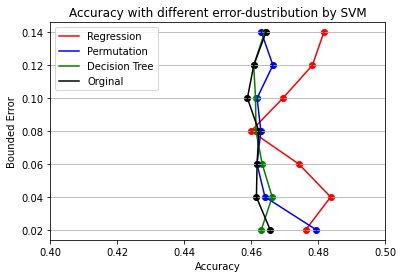

In [88]:
x = [BEAcclist_svm_importanceReg,BEAcclist_svm_importancePermu,BEAcclist_svm_importanceDTree,BEAcclist_svm]
y = [[0.02,0.04,0.06,0.08,0.1,0.12,0.14],[0.02,0.04,0.06,0.08,0.1,0.12,0.14],[0.02,0.04,0.06,0.08,0.1,0.12,0.14],[0.02,0.04,0.06,0.08,0.1,0.12,0.14]]

plt.xlim(0.4,0.5)
plt.title("Accuracy with different error-dustribution by SVM")
plt.xlabel("Accuracy")
plt.ylabel("Bounded Error")
color = ['red','blue','green','black']
label = ['Regression','Permutation','Decision Tree','Orginal']
# 設置y軸刻度
y_ticks = [0, 0.1, 0.2, 0.3, 0.4]

for i in range(len(x)):
    plt.scatter(x[i],y[i],color=color[i])
    plt.plot(x[i],y[i],color=color[i],label=label[i])
plt.grid(axis='y')
plt.legend()
#plt.savefig('D:\BESVM\BESVM\experimentpng\FourError-distribution_SVM_cmc.png')
plt.show()

In [60]:
#ch4 generate accuracy of applying FI in data with 2% - 14% err
#knn,cmc,importanceReg,Permu,DTree
BEn = [0.02,0.04,0.06,0.08,0.1,0.12,0.14]
BEAcclist_KNN_importanceReg = []
BEAcclist_KNN_importancePermu = []
BEAcclist_KNN_importanceDTree = []
BEAcclist_knn = []

for i in BEn :
    df_2feature_be = makeBEdata_4direc(X=dataset_2col,BE=i,importance=importanceReg)
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values

    X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.2,random_state=1)
    KNN_BE = KNeighborsClassifier()
    KNN_BE.fit(X_train, y_train)
    y_BE_predict = KNN_BE.predict(X_test)
    result_BE_train = KNN_BE.score(X_train, y_train)
    result_BE_test = KNN_BE.score(X_test, y_test)
    BEAcclist_KNN_importanceReg.append(result_BE_test)
    print('BEKNN Accuracy (on training) = with importanceReg bounded error '+str(i)+' : '+str(result_BE_train))
    print('BEKNN Accuracy (on testing) = with importanceReg bounded error '+str(i)+' : '+str(result_BE_test))

for i in BEn :
    df_2feature_be = makeBEdata_4direc(X=dataset_2col,BE=i,importance=importancePermu)
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values
    for j in range(30):
        X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.2)
        KNN_BE = KNeighborsClassifier()
        KNN_BE.fit(X_train, y_train)
        y_BE_predict = KNN_BE.predict(X_test)
        result_BE_train += KNN_BE.score(X_train, y_train)
        result_BE_test += KNN_BE.score(X_test, y_test)
    BEAcclist_KNN_importancePermu.append(result_BE_test/31)
    print('BEKNN Accuracy (on training) = with importancePermu bounded error '+str(i)+' : '+str(result_BE_train/31))
    print('BEKNN Accuracy (on testing) = with importancePermu bounded error '+str(i)+' : '+str(result_BE_test/31))
    result_BE_train = 0
    result_BE_test = 0

for i in BEn :
    df_2feature_be = makeBEdata_4direc(X=dataset_2col,BE=i,importance=importanceDTree)
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values
    for j in range(30):
        X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.2)
        KNN_BE = KNeighborsClassifier()
        KNN_BE.fit(X_train, y_train)
        y_BE_predict = KNN_BE.predict(X_test)
        result_BE_train += KNN_BE.score(X_train, y_train)
        result_BE_test += KNN_BE.score(X_test, y_test)
    BEAcclist_KNN_importanceDTree.append(result_BE_test/31)
    print('BEKNN Accuracy (on training) = with importanceDTree bounded error '+str(i)+' : '+str(result_BE_train/31))
    print('BEKNN Accuracy (on testing) = with importanceDTree bounded error '+str(i)+' : '+str(result_BE_test/31))
    result_BE_train = 0
    result_BE_test = 0

for i in BEn :
    df_2feature_be = makeBEdata_4direc(X=dataset_2col,BE=i)#1:1
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values
    for j in range(30):
        X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.2)
        KNN_BE = KNeighborsClassifier()
        KNN_BE.fit(X_train, y_train)
        y_BE_predict = KNN_BE.predict(X_test)
        result_BE_train += KNN_BE.score(X_train, y_train)
        result_BE_test += KNN_BE.score(X_test, y_test)
    BEAcclist_knn.append(result_BE_test/31)
    result_BE_test = 0
    result_BE_train = 0
    print('BEKNN Accuracy (on training) = with 1:1 bounded error '+str(i)+' : '+str(result_BE_train/31))
    print('BEKNN Accuracy (on testing) = with 1:1 bounded error '+str(i)+' : '+str(result_BE_test/31))



BEKNN Accuracy (on training) = with importanceReg bounded error 0.02 : 0.6042798913043478
BEKNN Accuracy (on testing) = with importanceReg bounded error 0.02 : 0.5271739130434783
BEKNN Accuracy (on training) = with importanceReg bounded error 0.04 : 0.6052989130434783
BEKNN Accuracy (on testing) = with importanceReg bounded error 0.04 : 0.5264945652173914
BEKNN Accuracy (on training) = with importanceReg bounded error 0.06 : 0.6024116847826086
BEKNN Accuracy (on testing) = with importanceReg bounded error 0.06 : 0.5217391304347826
BEKNN Accuracy (on training) = with importanceReg bounded error 0.08 : 0.5944293478260869
BEKNN Accuracy (on testing) = with importanceReg bounded error 0.08 : 0.5047554347826086
BEKNN Accuracy (on training) = with importanceReg bounded error 0.1 : 0.5949388586956522
BEKNN Accuracy (on testing) = with importanceReg bounded error 0.1 : 0.5027173913043478
BEKNN Accuracy (on training) = with importanceReg bounded error 0.12 : 0.5954483695652174
BEKNN Accuracy (o

In [61]:
print(BEAcclist_KNN_importanceReg)
print(BEAcclist_KNN_importancePermu)
print(BEAcclist_KNN_importanceDTree)
print(BEAcclist_knn)

[0.5271739130434783, 0.5264945652173914, 0.5217391304347826, 0.5047554347826086, 0.5027173913043478, 0.5040760869565217, 0.5027173913043478]
[0.507867286115007, 0.4894810659186536, 0.4783485273492286, 0.4787868162692846, 0.4767049438990181, 0.473702664796634, 0.4742943548387096]
[0.49116847826086957, 0.4869609046283309, 0.4795319074333802, 0.4812850631136044, 0.4800578541374475, 0.47510518934081347, 0.47652962833099577]
[0.4880566269284713, 0.4921984572230014, 0.4862377279102384, 0.48209589761570837, 0.4798387096774193, 0.47904978962131833, 0.47560922159887803]


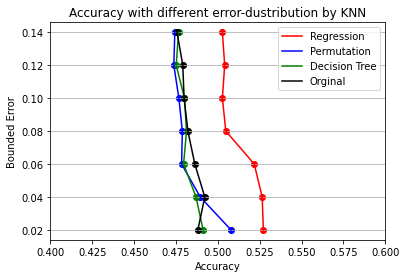

In [90]:
x = [BEAcclist_KNN_importanceReg,BEAcclist_KNN_importancePermu,BEAcclist_KNN_importanceDTree,BEAcclist_knn]
y = [[0.02,0.04,0.06,0.08,0.1,0.12,0.14],[0.02,0.04,0.06,0.08,0.1,0.12,0.14],[0.02,0.04,0.06,0.08,0.1,0.12,0.14],[0.02,0.04,0.06,0.08,0.1,0.12,0.14]]
plt.xlim(0.4,0.6)
plt.title("Accuracy with different error-dustribution by KNN")
plt.xlabel("Accuracy")
plt.ylabel("Bounded Error")
color = ['red','blue','green','black']
label = ['Regression','Permutation','Decision Tree','Orginal']

for i in range(len(x)):
    plt.scatter(x[i],y[i],color=color[i])
    plt.plot(x[i],y[i],color=color[i],label=label[i])

plt.grid(axis='y')
plt.legend()
#plt.savefig('D:\BESVM\BESVM\experimentpng\FourError-distribution_KNN_cmc.png')

plt.show()

In [95]:
#ch4 generate accuracy of applying FI in data with 2%-14% err
#kmeans,cmc,importanceReg,Permu,DTree
BEn =[0.02,0.04,0.06,0.08,0.1,0.12,0.14]
BEAcclist_KM_importanceReg = []
BEAcclist_KM_importancePermu = []
BEAcclist_KM_importanceDTree = []
BEAcclist_km = []

for i in BEn :
    df_2feature_be = makeBEdata_4direc(X=dataset_2col,BE=i,importance=importanceReg)
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values

    for j in range(30):
        X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.3)
        KM_BE=KMeans(n_clusters=3,init='random')
        KM_BE.fit(X_train)
        y_BE_predict = KM_BE.predict(X_train)
        y_BE_predict_test = KM_BE.predict(X_test)
        result_BE_train += 1 - np.sum(y_BE_predict!=y_train)/len(y_train)
        result_BE_test += 1 - np.sum(y_BE_predict_test!=y_train)/len(y_test)
    BEAcclist_KM_importanceReg.append(result_BE_test/31)
    print('BEKM Accuracy (on training) = with importanceReg bounded error '+str(i)+' : '+str(result_BE_train/31))
    print('BEKM Accuracy (on testing) = with importanceReg bounded error '+str(i)+' : '+str(result_BE_test/31))
    result_BE_train = 0
    result_BE_test = 0
    
for i in BEn :
    df_2feature_be = makeBEdata_4direc(X=dataset_2col,BE=i,importance=importancePermu)
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values

    for j in range(30):
        X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.3)
        KM_BE=KMeans(n_clusters=3,init='random')
        KM_BE.fit(X_train)
        y_BE_predict = KM_BE.predict(X_train)
        y_BE_predict_test = KM_BE.predict(X_test)
        result_BE_train += 1 - np.sum(y_BE_predict!=y_train)/len(y_train)
        result_BE_test += 1 - np.sum(y_BE_predict_test!=y_train)/len(y_test)
    BEAcclist_KM_importancePermu.append(result_BE_test/31)
    print('BEKM Accuracy (on training) = with importancePermu bounded error '+str(i)+' : '+str(result_BE_train/31))
    print('BEKM Accuracy (on testing) = with importancePermu bounded error '+str(i)+' : '+str(result_BE_test/31))
    result_BE_train = 0
    result_BE_test = 0

for i in BEn :
    df_2feature_be = makeBEdata_4direc(X=dataset_2col,BE=i,importance=importanceDTree)
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values
    for j in range(30):
        X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.3)
        KM_BE=KMeans(n_clusters=3,init='random')
        KM_BE.fit(X_train)
        y_BE_predict = KM_BE.predict(X_train)
        y_BE_predict_test = KM_BE.predict(X_test)
        result_BE_train += 1 - np.sum(y_BE_predict!=y_train)/len(y_train)
        result_BE_test += 1 - np.sum(y_BE_predict_test!=y_train)/len(y_test)
    BEAcclist_KM_importanceDTree.append(result_BE_test/31)
    print('BEKM Accuracy (on training) = with importanceDTree bounded error '+str(i)+' : '+str(result_BE_train/31))
    print('BEKM Accuracy (on testing) = with importanceDTree bounded error '+str(i)+' : '+str(result_BE_test/31))
    result_BE_train = 0
    result_BE_test = 0

for i in BEn :
    df_2feature_be = makeBEdata_4direc(X=dataset_2col,BE=i)
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values
    for j in range(30):
        X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.3)
        KM_BE=KMeans(n_clusters=3,init='random')
        KM_BE.fit(X_train)
        y_BE_predict_test = KM_BE.predict(X_test)
        result_BE_train += 1 - np.sum(y_BE_predict!=y_train)/len(y_train)
        result_BE_test += 1 - np.sum(y_BE_predict_test!=y_train)/len(y_test)
    BEAcclist_km.append(result_BE_test/31)
    print('BEKM Accuracy (on training) = with 1:1 bounded error '+str(i)+' : '+str(result_BE_train/31))
    print('BEKM Accuracy (on testing) = with 1:1 bounded error '+str(i)+' : '+str(result_BE_test/31))
    result_BE_train = 0
    result_BE_test = 0

BEKM Accuracy (on training) = with importanceReg bounded error 0.02 : 0.20150020036064922
BEKM Accuracy (on testing) = with importanceReg bounded error 0.02 : 0.9673036465638141
BEKM Accuracy (on training) = with importanceReg bounded error 0.04 : 0.2102597174914847
BEKM Accuracy (on testing) = with importanceReg bounded error 0.04 : 0.9673036465638141
BEKM Accuracy (on training) = with importanceReg bounded error 0.06 : 0.21603886996593868
BEKM Accuracy (on testing) = with importanceReg bounded error 0.06 : 0.9673036465638141
BEKM Accuracy (on training) = with importanceReg bounded error 0.08 : 0.20345997796032858
BEKM Accuracy (on testing) = with importanceReg bounded error 0.08 : 0.9673036465638141
BEKM Accuracy (on training) = with importanceReg bounded error 0.1 : 0.21066043878982169
BEKM Accuracy (on testing) = with importanceReg bounded error 0.1 : 0.9673036465638141
BEKM Accuracy (on training) = with importanceReg bounded error 0.12 : 0.20541349428972147
BEKM Accuracy (on testi

In [96]:
print(BEAcclist_KM_importanceReg)
print(BEAcclist_KM_importancePermu)
print(BEAcclist_KM_importanceDTree)
print(BEAcclist_km)

[0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141]
[0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141]
[0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141]
[0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141, 0.9673036465638141]


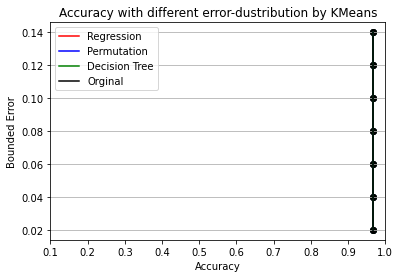

In [100]:
x = [BEAcclist_KM_importanceReg,BEAcclist_KM_importancePermu,BEAcclist_KM_importanceDTree,BEAcclist_km]
y = [[0.02,0.04,0.06,0.08,0.1,0.12,0.14],[0.02,0.04,0.06,0.08,0.1,0.12,0.14],[0.02,0.04,0.06,0.08,0.1,0.12,0.14],[0.02,0.04,0.06,0.08,0.1,0.12,0.14]]
plt.xlim(0.1,1.0)
plt.title("Accuracy with different error-dustribution by KMeans")
plt.xlabel("Accuracy")
plt.ylabel("Bounded Error")
color = ['red','blue','green','black']
label = ['Regression','Permutation','Decision Tree','Orginal']

for i in range(len(x)):
    plt.scatter(x[i],y[i],color=color[i])
    plt.plot(x[i],y[i],color=color[i],label=label[i])

plt.grid(axis='y')
plt.legend()
#plt.savefig('D:\BESVM\BESVM\experimentpng\FourError-distribution_KM_cmc.png')
plt.show()

In [66]:
ratio = [[0.0,1.0],[0.05,0.95],[0.1,0.9],[0.15,0.85],
         [0.2,0.8],[0.25,0.75],[0.3,0.7],[0.35,0.65],
         [0.4,0.6],[0.45,0.55],[0.5,0.5],[0.55,0.45],
         [0.6,0.4],[0.65,0.35],[0.7,0.3],[0.75,0.25],
         [0.8,0.2],[0.85,0.15],[0.9,0.1],[0.95,0.05],[1.0,0.0]]
BEACClist_bruteForce_svm=[]
BE = 0.1
for i in range(21) :
    df_2feature_be = makeBEdata_4direc(X=dataset_2col,importance=ratio[i])
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values
    for j in range(30):
        X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.2)
        clf_BE = SVC(kernel='linear',C=1,gamma='auto')
        clf_BE.fit(X_train, y_train)
        y_BE_predict = clf_BE.predict(X_test)
        result_BE_train += clf_BE.score(X_train, y_train)
        result_BE_test += clf_BE.score(X_test, y_test)
    BEACClist_bruteForce_svm.append(result_BE_test/31)
    print('BESVM Accuracy (on training) = with x1 bounded error ('+str(BE)+'%*'+str(ratio[i][0])+'),x2 with error ('+str(BE)+'%*'+str(ratio[i][1])+') : '+str(result_BE_train/31))
    print('BESVM Accuracy (on testing) = with x1 bounded error ('+str(BE)+'%*'+str(ratio[i][0])+'),x2 with error ('+str(BE)+'%*'+str(ratio[i][1])+') : '+str(result_BE_test/31))
    result_BE_train = 0
    result_BE_test = 0

BESVM Accuracy (on training) = with x1 bounded error (0.1%*0.0),x2 with error (0.1%*1.0) : 0.46322208099579243
BESVM Accuracy (on testing) = with x1 bounded error (0.1%*0.0),x2 with error (0.1%*1.0) : 0.46193460729312763
BESVM Accuracy (on training) = with x1 bounded error (0.1%*0.05),x2 with error (0.1%*0.95) : 0.4633700035063113
BESVM Accuracy (on testing) = with x1 bounded error (0.1%*0.05),x2 with error (0.1%*0.95) : 0.46289884291725103
BESVM Accuracy (on training) = with x1 bounded error (0.1%*0.1),x2 with error (0.1%*0.9) : 0.4642465813464235
BESVM Accuracy (on testing) = with x1 bounded error (0.1%*0.1),x2 with error (0.1%*0.9) : 0.46370967741935476
BESVM Accuracy (on training) = with x1 bounded error (0.1%*0.15),x2 with error (0.1%*0.85) : 0.4647506136044881
BESVM Accuracy (on testing) = with x1 bounded error (0.1%*0.15),x2 with error (0.1%*0.85) : 0.46015953716690033
BESVM Accuracy (on training) = with x1 bounded error (0.1%*0.2),x2 with error (0.1%*0.8) : 0.46303032959326784


In [67]:
print(BEACClist_bruteForce_svm)
print(importanceReg)
print(BEAcclist_svm_importanceReg[4])
print(BEAcclist_svm_importancePermu[4])

[0.46193460729312763, 0.46289884291725103, 0.46370967741935476, 0.46015953716690033, 0.46495880084151475, 0.46465199859747547, 0.4616935483870968, 0.46151823281907434, 0.46390690743338, 0.4651341164095371, 0.46055399719495094, 0.4609484572230014, 0.45864744039270683, 0.4654409186535765, 0.46127717391304357, 0.46357819074333795, 0.4610799438990182, 0.4651560308555399, 0.46107994389901824, 0.46421370967741943, 0.4644766830294531]
[0.41885338838398556, 0.5811466116160146]
0.469429347826087
0.46171546283309955


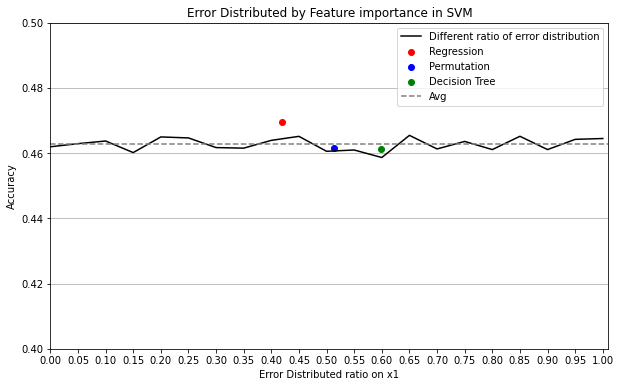

In [87]:
#svm,cmc
x = [[0.0,0.05,0.1,0.15,0.2,
     0.25,0.3,0.35,0.4,
     0.45,0.5,0.55,0.6,
     0.65,0.7,0.75,0.8,
     0.85,0.9,0.95,1.0]]
y = [BEACClist_bruteForce_svm]
x_importance = [importanceReg[0],importancePermu[0],importanceDTree[0]]
y_importance = [BEAcclist_svm_importanceReg[4],BEAcclist_svm_importancePermu[4],BEAcclist_svm_importanceDTree[4]]
avg = np.mean(y)
fig = plt.figure(figsize=(10,6))
x_major_locator=MultipleLocator(0.05)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim(0.0,1.01)
plt.ylim(0.4,0.5)
plt.grid(axis='y')
plt.plot(x[0],y[0],color='black',label="Different ratio of error distribution")
plt.scatter(x_importance[0],y_importance[0],color=color[0],label="Regression")
plt.scatter(x_importance[1],y_importance[1],color=color[1],label='Permutation')
plt.scatter(x_importance[2],y_importance[2],color=color[2],label="Decision Tree")
plt.axhline(y=avg,color="gray",linestyle = '--',label="Avg")
plt.title("Error Distributed by Feature importance in SVM")
plt.ylabel("Accuracy")
plt.xlabel("Error Distributed ratio on x1")
#plt.savefig('D:\BESVM\BESVM\experimentpng\ErrorDistributedFI_SVM_vs_Avg_cmc.png')
plt.legend()
plt.show()


In [79]:
ratio = [[0.0,1.0],[0.05,0.95],[0.1,0.9],[0.15,0.85],
         [0.2,0.8],[0.25,0.75],[0.3,0.7],[0.35,0.65],
         [0.4,0.6],[0.45,0.55],[0.5,0.5],[0.55,0.45],
         [0.6,0.4],[0.65,0.35],[0.7,0.3],[0.75,0.25],
         [0.8,0.2],[0.85,0.15],[0.9,0.1],[0.95,0.05],[1.0,0.0]]
BEACClist_bruteForce_knn=[]
BE = 0.1
for i in range(21) :
    df_2feature_be = makeBEdata_4direc(importance=ratio[i])
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values
    for j in range(30):
        X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.2)
        KNN_BE = KNeighborsClassifier()
        KNN_BE.fit(X_train, y_train)
        y_BE_predict = KNN_BE.predict(X_test)
        result_BE_train += KNN_BE.score(X_train, y_train)
        result_BE_test += KNN_BE.score(X_test, y_test)
    BEACClist_bruteForce_knn.append(result_BE_test/31)
    print('BEKNNN Accuracy (on training) = with x1 bounded error ('+str(BE)+'%*'+str(ratio[i][0])+'),x2 with error ('+str(BE)+'%*'+str(ratio[i][1])+') : '+str(result_BE_train/31))
    print('BEKNN Accuracy (on testing) = with x1 bounded error ('+str(BE)+'%*'+str(ratio[i][0])+'),x2 with error ('+str(BE)+'%*'+str(ratio[i][1])+') : '+str(result_BE_test/31))
    result_BE_train = 0
    result_BE_test = 0

BEKNNN Accuracy (on training) = with x1 bounded error (0.1%*0.0),x2 with error (0.1%*1.0) : 0.5738133327489482
BEKNN Accuracy (on testing) = with x1 bounded error (0.1%*0.0),x2 with error (0.1%*1.0) : 0.5092259817671809
BEKNNN Accuracy (on training) = with x1 bounded error (0.1%*0.05),x2 with error (0.1%*0.95) : 0.5879591076437587
BEKNN Accuracy (on testing) = with x1 bounded error (0.1%*0.05),x2 with error (0.1%*0.95) : 0.49419267180925663
BEKNNN Accuracy (on training) = with x1 bounded error (0.1%*0.1),x2 with error (0.1%*0.9) : 0.5862990883590463
BEKNN Accuracy (on testing) = with x1 bounded error (0.1%*0.1),x2 with error (0.1%*0.9) : 0.4910369915848527
BEKNNN Accuracy (on training) = with x1 bounded error (0.1%*0.15),x2 with error (0.1%*0.85) : 0.5879536290322582
BEKNN Accuracy (on testing) = with x1 bounded error (0.1%*0.15),x2 with error (0.1%*0.85) : 0.49101507713885006
BEKNNN Accuracy (on training) = with x1 bounded error (0.1%*0.2),x2 with error (0.1%*0.8) : 0.5854553821879384

In [84]:
print(BEAcclist_KNN_importanceReg[4])

0.5027173913043478


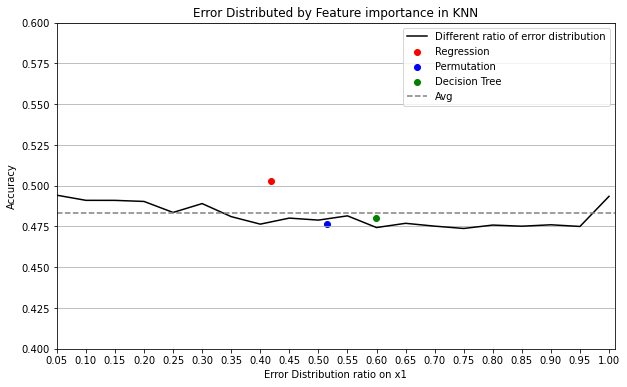

In [89]:
#knn,cmc
x = [[0,0.05,0.1,0.15,0.2,
     0.25,0.3,0.35,0.4,
     0.45,0.5,0.55,0.6,
     0.65,0.7,0.75,0.8,
     0.85,0.9,0.95,1.0]]
y = [BEACClist_bruteForce_knn]
x_importance = [importanceReg[0],importancePermu[0],importanceDTree[0]]
y_importance = [BEAcclist_KNN_importanceReg[4],BEAcclist_KNN_importancePermu[4],BEAcclist_KNN_importanceDTree[4]]
avg = np.mean(y)
fig = plt.figure(figsize=(10,6))
x_major_locator=MultipleLocator(0.05)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim(0.05,1.01)
plt.ylim(0.4,0.6)
plt.grid(axis='y')
plt.plot(x[0],y[0],color='black',label="Different ratio of error distribution")
plt.scatter(x_importance[0],y_importance[0],color=color[0],label="Regression")
plt.scatter(x_importance[1],y_importance[1],color=color[1],label='Permutation')
plt.scatter(x_importance[2],y_importance[2],color=color[2],label="Decision Tree")
plt.axhline(y=avg,color="gray",linestyle = '--',label="Avg")
plt.title("Error Distributed by Feature importance in KNN")
plt.ylabel("Accuracy")
plt.xlabel("Error Distribution ratio on x1")
#plt.savefig('D:\BESVM\BESVM\experimentpng\ErrorDistributedFI_KNN_vs_Avg_cmc.png')
plt.legend()
plt.show()

In [81]:
ratio = [[0.0,1.0],[0.05,0.95],[0.1,0.9],[0.15,0.85],
         [0.2,0.8],[0.25,0.75],[0.3,0.7],[0.35,0.65],
         [0.4,0.6],[0.45,0.55],[0.5,0.5],[0.55,0.45],
         [0.6,0.4],[0.65,0.35],[0.7,0.3],[0.75,0.25],
         [0.8,0.2],[0.85,0.15],[0.9,0.1],[0.95,0.05],[1.0,0.0]]
BEACClist_bruteForce_km=[]
BE = 0.1
for i in range(21) :
    df_2feature_be = makeBEdata_4direc(importance=ratio[i])
    x_be = df_2feature_be.iloc[:, :-1].values
    y_be = df_2feature_be.iloc[:,-1].values
    for j in range(30):
        X_train,X_test,y_train, y_test = train_test_split(x_be, y_be, test_size=0.3)
        KM_BE=KMeans(n_clusters=2,init='random')
        KM_BE.fit(X_train)
        y_BE_predict = KM_BE.predict(X_train)
        y_BE_predict_test = KM_BE.predict(X_test)
        result_BE_train += 1 - np.sum(y_BE_predict!=y_train)/len(y_train)
        result_BE_test += 1 - np.sum(y_BE_predict_test!=y_train)/len(y_test)
    BEACClist_bruteForce_km.append(result_BE_test/31)
    print('BKM Accuracy (on training) = with x1 bounded error ('+str(BE)+'%*'+str(ratio[i][0])+'),x2 with error ('+str(BE)+'%*'+str(ratio[i][1])+') : '+str(result_BE_train/31))
    print('BKM Accuracy (on testing) = with x1 bounded error ('+str(BE)+'%*'+str(ratio[i][0])+'),x2 with error ('+str(BE)+'%*'+str(ratio[i][1])+') : '+str(result_BE_test/31))
    result_BE_train = 0
    result_BE_test = 0

BKM Accuracy (on training) = with x1 bounded error (0.1%*0.0),x2 with error (0.1%*1.0) : 0.20451813263874974
BKM Accuracy (on testing) = with x1 bounded error (0.1%*0.0),x2 with error (0.1%*1.0) : 0.9673036465638141
BKM Accuracy (on training) = with x1 bounded error (0.1%*0.05),x2 with error (0.1%*0.95) : 0.20587682829092369
BKM Accuracy (on testing) = with x1 bounded error (0.1%*0.05),x2 with error (0.1%*0.95) : 0.9673036465638141
BKM Accuracy (on training) = with x1 bounded error (0.1%*0.1),x2 with error (0.1%*0.9) : 0.20516304347826086
BKM Accuracy (on testing) = with x1 bounded error (0.1%*0.1),x2 with error (0.1%*0.9) : 0.9673036465638141
BKM Accuracy (on training) = with x1 bounded error (0.1%*0.15),x2 with error (0.1%*0.85) : 0.2087069224604288
BKM Accuracy (on testing) = with x1 bounded error (0.1%*0.15),x2 with error (0.1%*0.85) : 0.9673036465638141
BKM Accuracy (on training) = with x1 bounded error (0.1%*0.2),x2 with error (0.1%*0.8) : 0.20485624123422155
BKM Accuracy (on tes

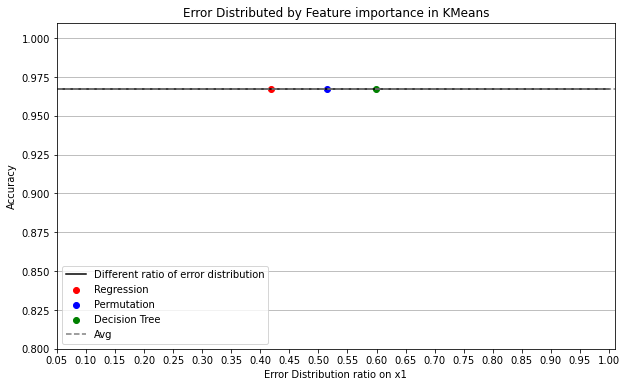

In [101]:
#kmeans,cmc
y = [BEACClist_bruteForce_km]
x = [[0,0.05,0.1,0.15,0.2,
     0.25,0.3,0.35,0.4,
     0.45,0.5,0.55,0.6,
     0.65,0.7,0.75,0.8,
     0.85,0.9,0.95,1.0]]
x_importance = [importanceReg[0],importancePermu[0],importanceDTree[0]]
y_importance = [BEAcclist_KM_importanceReg[4],BEAcclist_KM_importancePermu[4],BEAcclist_KM_importanceDTree[4]]
avg = np.mean(y)
fig = plt.figure(figsize=(10,6))
x_major_locator=MultipleLocator(0.05)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim(0.05,1.01)
plt.ylim(0.8,1.01)
plt.grid(axis='y')
plt.plot(x[0],y[0],color='black',label="Different ratio of error distribution")
plt.scatter(x_importance[0],y_importance[0],color=color[0],label="Regression")
plt.scatter(x_importance[1],y_importance[1],color=color[1],label='Permutation')
plt.scatter(x_importance[2],y_importance[2],color=color[2],label="Decision Tree")
plt.axhline(y=avg,color="gray",linestyle = '--',label="Avg")
plt.title("Error Distributed by Feature importance in KMeans")
plt.ylabel("Accuracy")
plt.xlabel("Error Distribution ratio on x1")
#plt.savefig('D:\BESVM\BESVM\experimentpng\ErrorDistributedFI_KMeans_cmc_vs_Avg.png')
plt.legend()
plt.show()


